### Load pakcages

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot

import gtra


from pathlib import Path


DATA_PATH = Path("/data3/projects/2025_GTRA/data/1_MND")

### Load data

In [2]:
# scRNA-seq data
adata = sc.read_h5ad(DATA_PATH / "CCTSD_preproc.h5ad")
adata = adata[:,adata.var.highly_variable].copy()

# meta data (Option: answer path)
answer_path_type = "MND"
answer_path_dir =   "../answer_paths/MND_answer.csv"

### Upload time-series scRNA-seq data

In [3]:
gtra_obj = gtra.GTraObject()
gtra_obj.params.cell_type_label = "cell_type2"
gtra_obj.params.output_dir = "./MND_out"
gtra_obj.params.output_name = "Mouse"
gtra_obj.params.answer_path_type = "MND"
gtra_obj.params.answer_path_dir = answer_path_dir

# Upload time-series scRNA_seq data
for time in sorted(adata.obs["timepoints"].unique()):
    dat = adata[adata.obs["timepoints"]==time]
    cnt_dat = dat.to_df(layer="counts")
    meta = dat.obs[[gtra_obj.params.cell_type_label]]
    gtra_obj.upload_time_scRNA(cnt_dat, meta)

gtra_obj.select_genes()

### Run GTra

In [4]:
gtra_obj.find_gclusters(N=50)

Step 1: Identifying cell type-specific gene clusters...


In [5]:
gtra_obj.construct_trajectories()

Step 2: Constructing cell-state trajectories..:   0%|                         | 0/3 [00:00<?, ?it/s]

Step 2: Constructing cell-state trajectories..: 100%|=================| 3/3 [00:16<00:00,  5.46s/it]


In [6]:
gtra_obj.pattern_clustering()

Step 3: Detecting time-series pattern clustering...: 100%|==========| 19/19 [00:00<00:00, 26.40it/s]


### Visualization

In [7]:
gtra_obj.params.time_point_label = ["E11.5", "E13.5", "E15.5", "E17.5"]

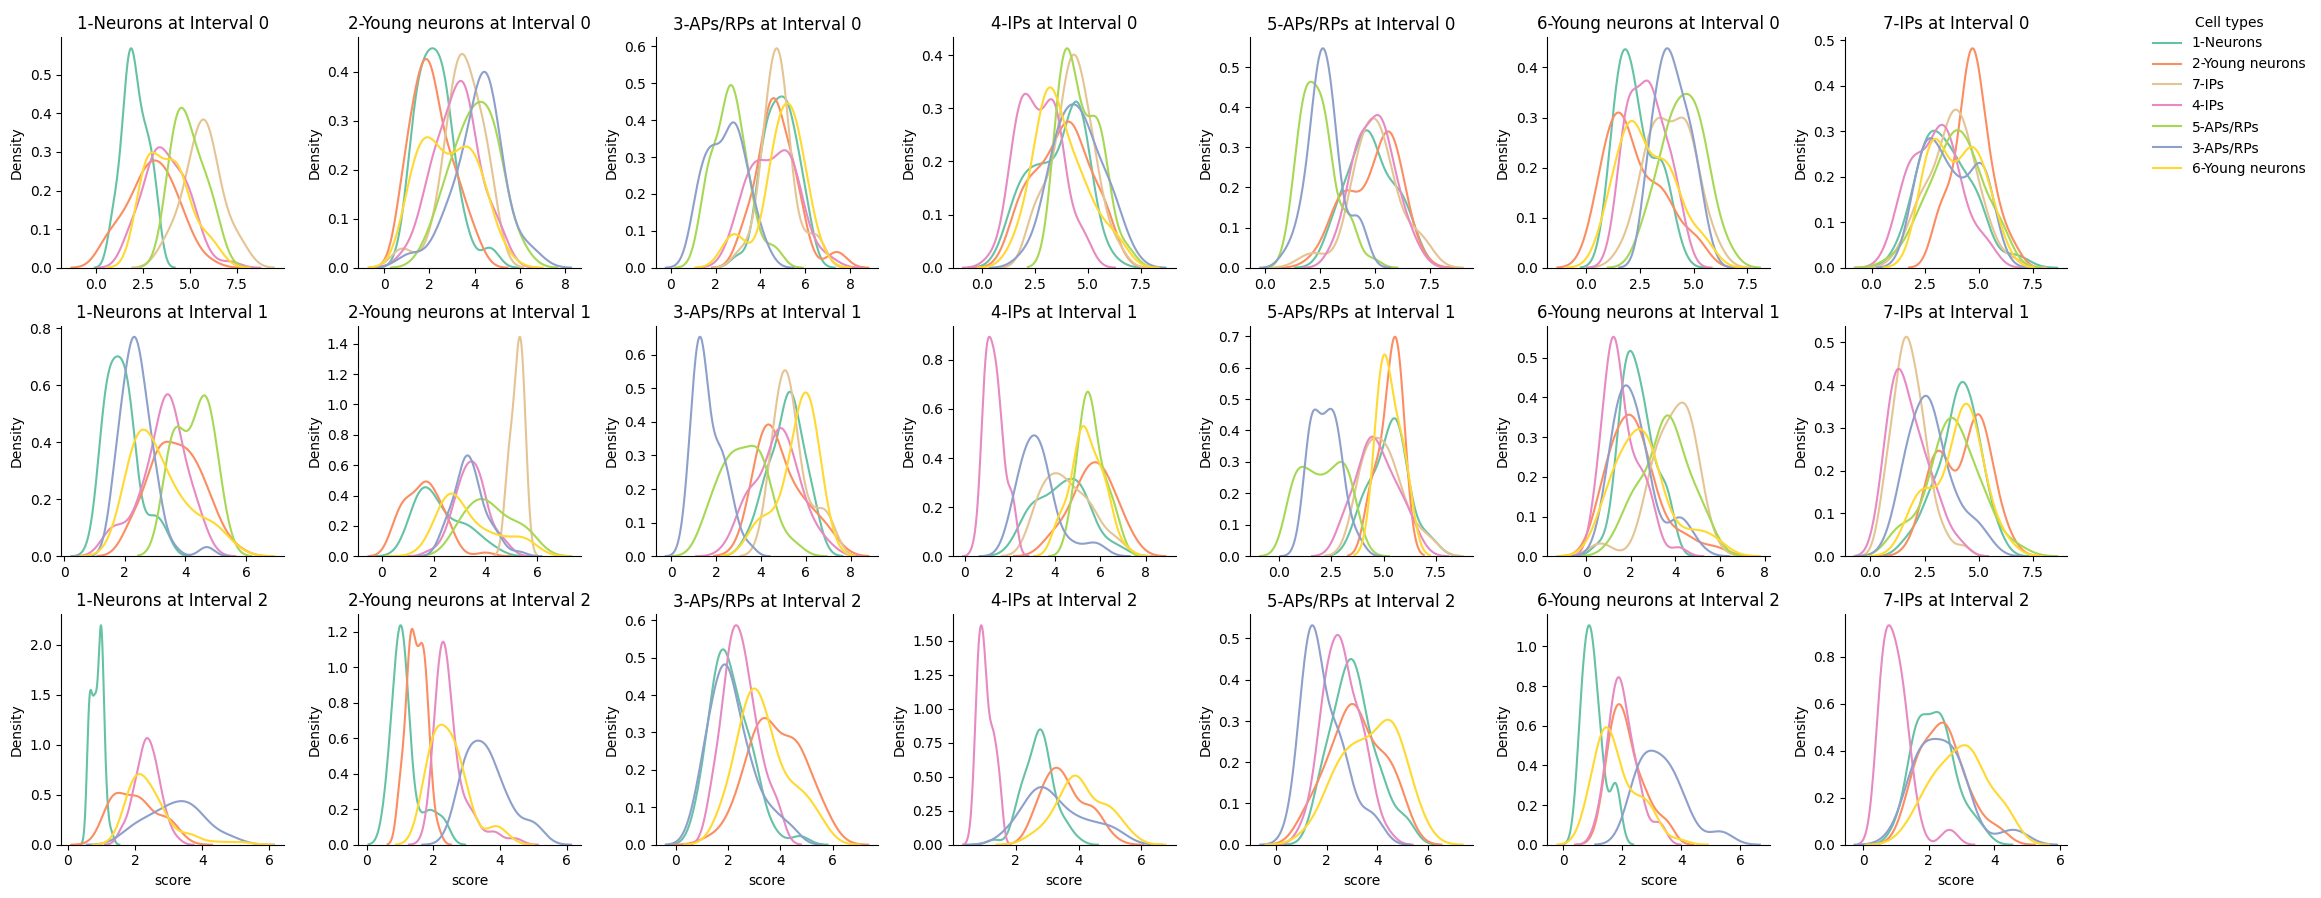

In [8]:
gtra_obj.plot_edge_statistic()

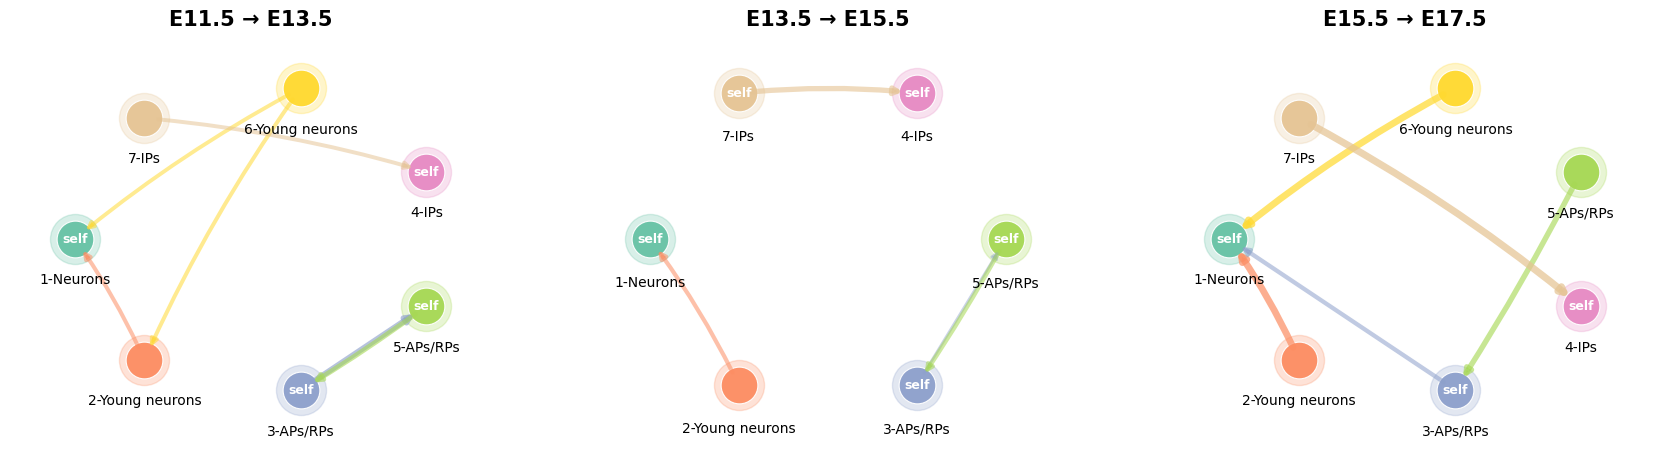

In [9]:
gtra_obj.plot_cell_state_graph()

Plotting time-series gene expression patterns...


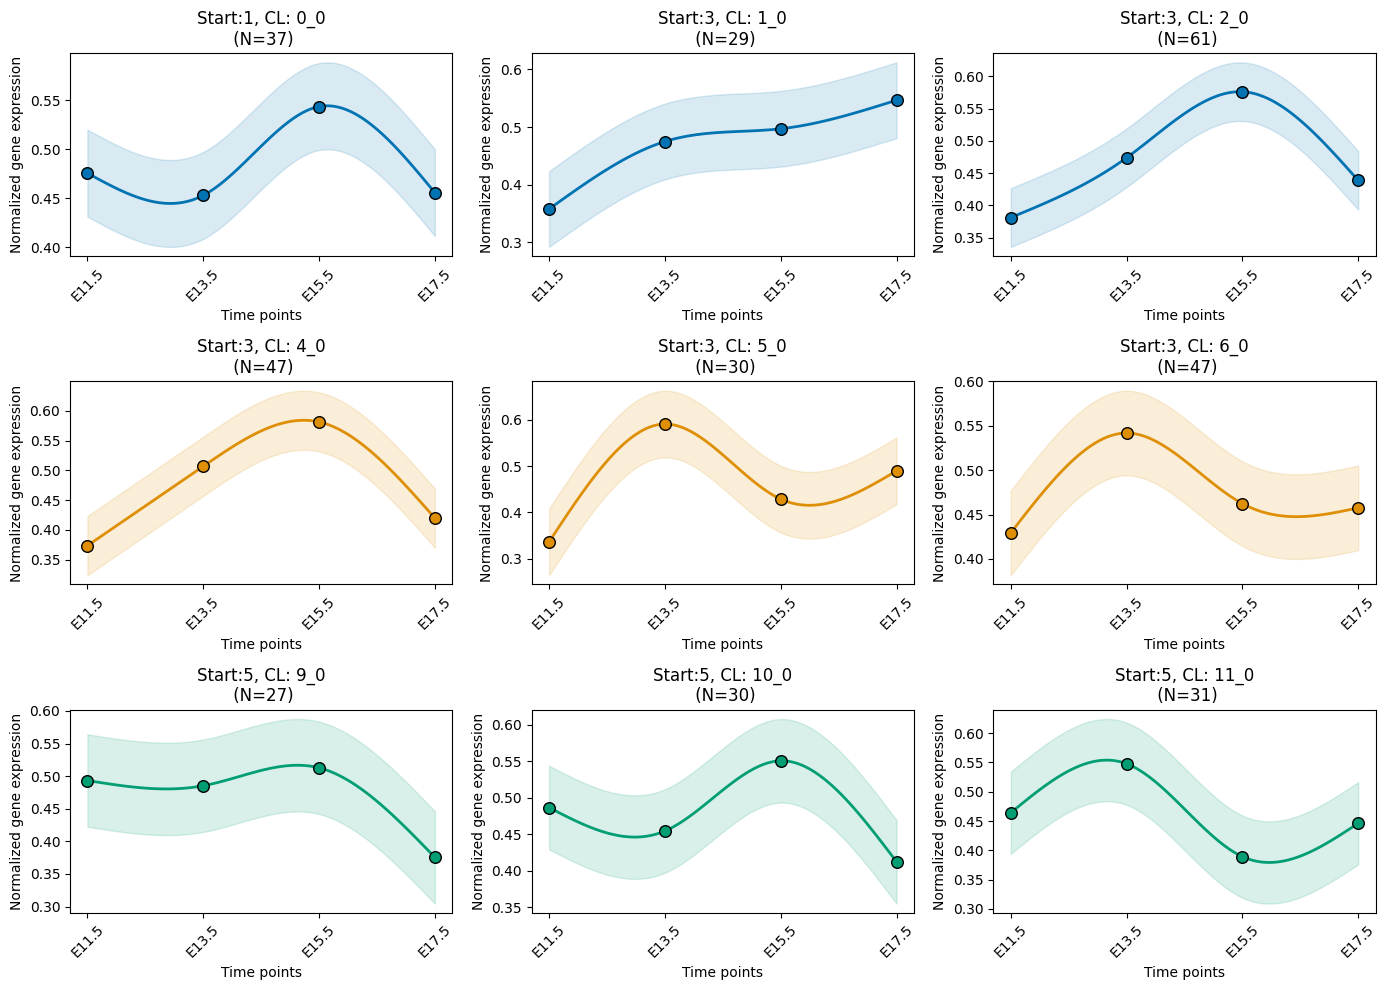

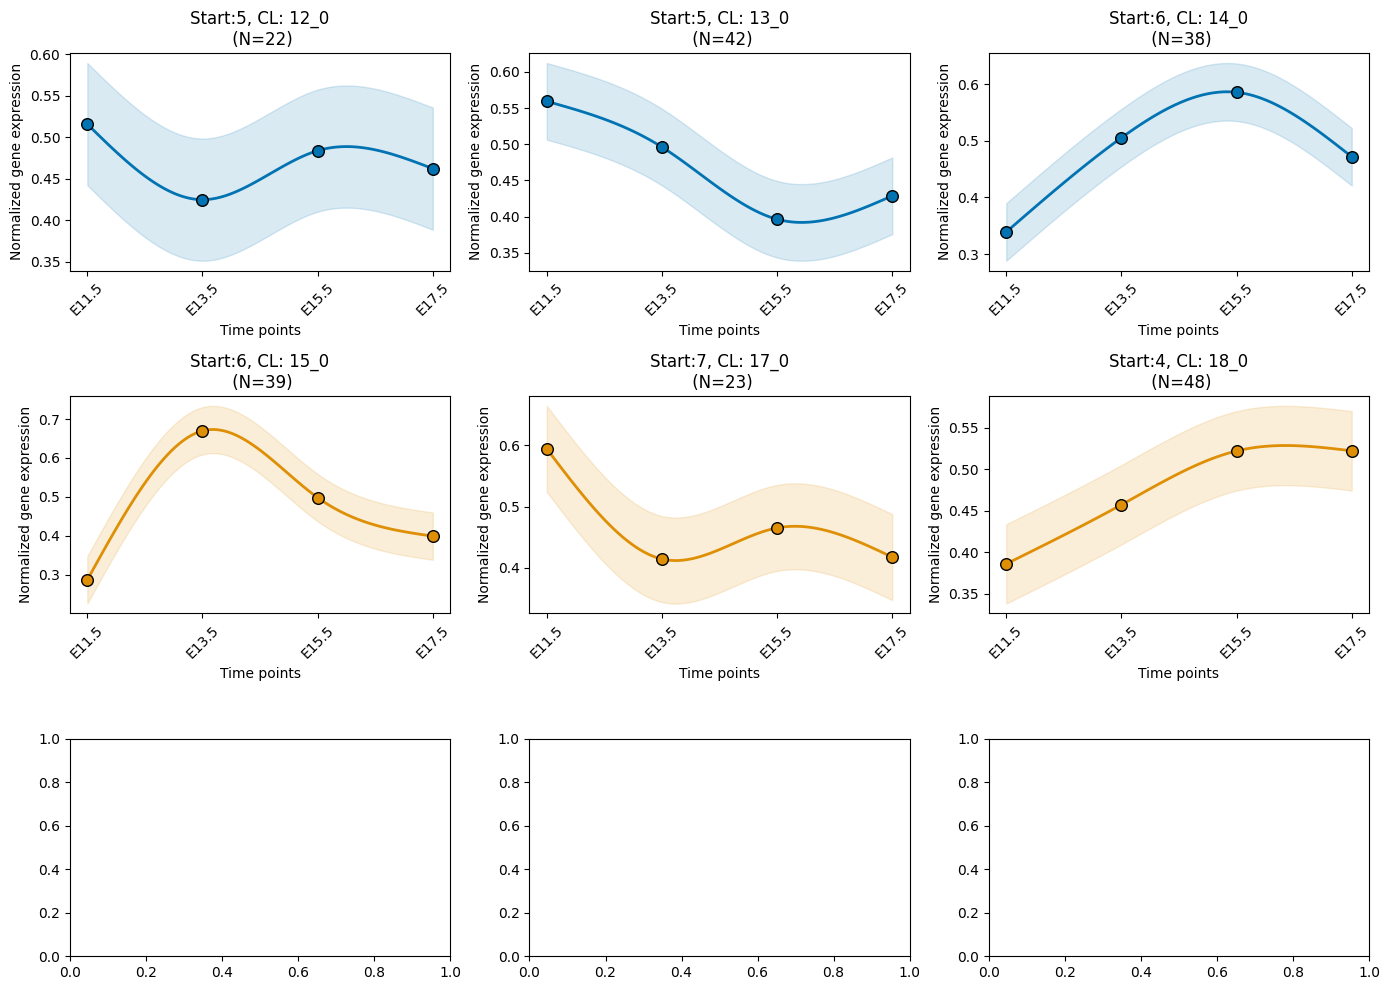

In [10]:
gtra_obj.plot_patterns()

In [11]:
gtra_obj.plot_trajectory()

RuntimeError: 

Kaleido requires Google Chrome to be installed.

Either download and install Chrome yourself following Google's instructions for your operating system,
or install it from your terminal by running:

    $ plotly_get_chrome



### Post analysis

In [ ]:
gtra_obj.module_evaluation()

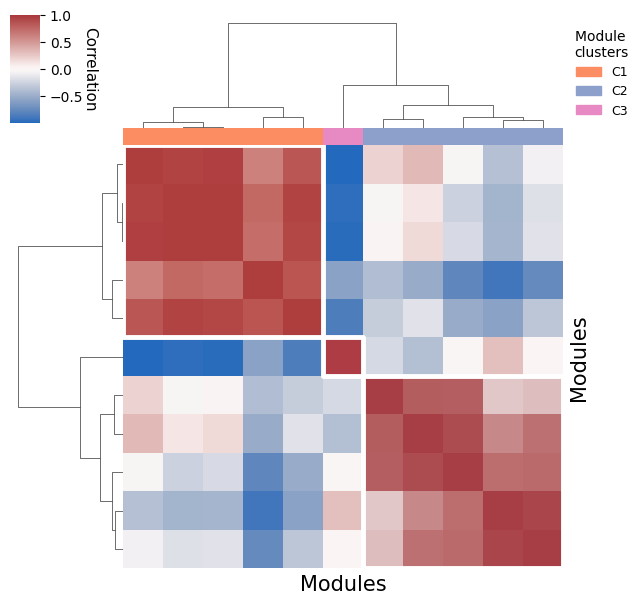

In [ ]:
gtra_obj.plot_module_cluster()

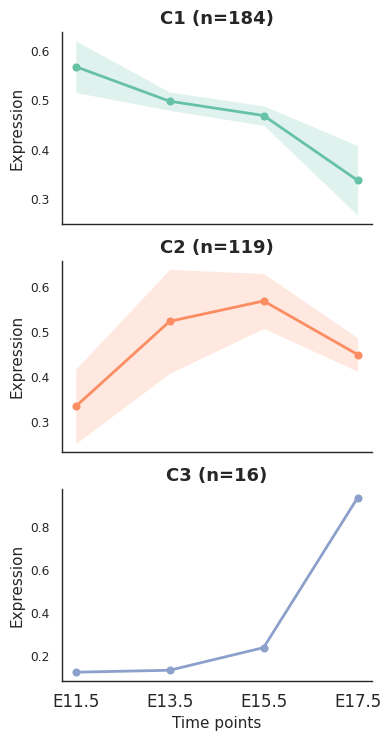

In [ ]:
gtra_obj.plot_rep_patterns()


### Enrichment analysis for module cluster

In [ ]:
pt_df = gtra_obj.module_df.copy()
res_df = gtra_obj.sig_patterns.copy()

cgenes_dict = dict()

for c, d in pt_df.groupby("cluster"):
    tmp = []
    for pt in d["Pattern_ID"].values:
        gv = res_df[res_df["Pattern_ID"] == pt]["Genes"].values[0]
        gs = gv.split(';')
        tmp.extend(gs)
    cgenes_dict[c]=set(tmp)

In [ ]:
import gseapy as gp

names = gp.get_library_name(organism="Mouse")
enr_c1 = gp.enrichr(gene_list=list(cgenes_dict[1]),
           gene_sets=["GO_Biological_Process_2025"],
           organism="Mouse",
           outdir=None)
enr_c2 = gp.enrichr(gene_list=list(cgenes_dict[2]),
           gene_sets=["GO_Biological_Process_2025"],
           organism="Mouse",
           outdir=None)
enr_c3 = gp.enrichr(gene_list=list(cgenes_dict[3]),
           gene_sets=["GO_Biological_Process_2025"],
           organism="Mouse",
           outdir=None)


In [ ]:
enr_c1.res2d["Cluster"] = "C1"
enr_c2.res2d["Cluster"] = "C2"
enr_c3.res2d["Cluster"] = "C3"
enr_res = pd.concat([enr_c1.res2d, enr_c2.res2d,enr_c3.res2d])

def shorten_term(term):
    replacements = {
        "Regulation": "Reg.",
        "Positive": "Pos.",
        "Negative": "Neg.",
        "Transcription": "Tx",
        "DNA-templated": "DNA-tmp",
        "RNA Polymerase II": "Pol II",
        "Process": "Proc.",
        "Development": "Dev."
    }
    for long, short in replacements.items():
        term = term.replace(long, short)
    return term

enr_res['Short_term'] = enr_res['Term'].apply(shorten_term)

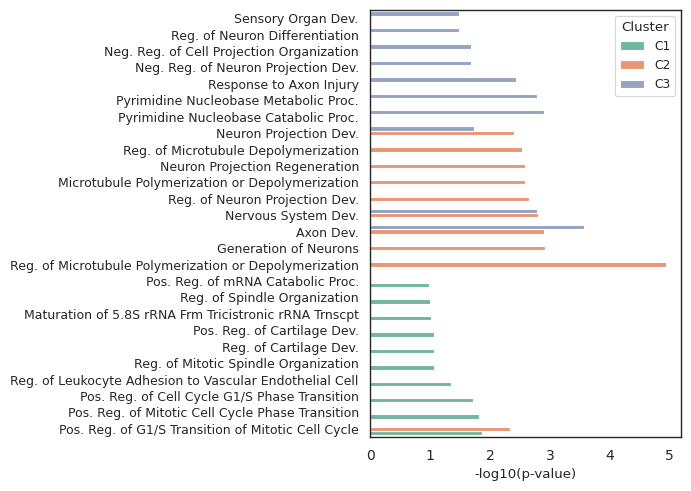

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

cb_palette = sns.color_palette("Set2", 3)
enr_res['-log10(p-value)'] = -np.log10(enr_res['Adjusted P-value'])

df_plot = enr_res.copy()
df_plot['Short_term'] = df_plot['Term'].apply(shorten_term).str.replace(r"\s*\(GO:\d+\)", "", regex=True)
df_plot = df_plot.sort_values(by='-log10(p-value)', ascending=False)
mdf = pd.DataFrame()
for idx, (c,df) in enumerate(df_plot.groupby('Cluster')):
    sel_df = df.head(10).copy()
    if idx == 0:
        mdf = sel_df
    else:
        mdf = pd.concat([mdf, sel_df])

df_plot =mdf.copy()
# plot
plt.figure(figsize=(7,5))
sns.barplot(data=df_plot.head(30),
            x='-log10(p-value)',
            y='Short_term',
            palette={"C1":cb_palette[0],"C2":cb_palette[1],"C3":cb_palette[2]},
            hue='Cluster'
            )

plt.xlabel('-log10(p-value)')
plt.ylabel('')

plt.xticks(fontsize=10)
plt.yticks(fontsize=9)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()